<img src="images/ipsa_logo.png" width="100" align="right">

# Ma422- 2022/2023 

# <font color='black'> Introduction to Machine Learning</font>

---
 
 
1. [Set-Up](#Set-Up)
2. [Multi-class Classification](#NN)
 * [Visualizing the data](#MR)
 * [Vectorizing logistic regression](#MR)
 * [One-vs-all classication](#MR)

---

The objective of this lab session is to deal with the multi-class classification.


## <font color='black'>Set-Up</font>

---

First we will import the packages that we will need throughout the notebook.

In [44]:
import os
import numpy as np
from matplotlib import pyplot
from scipy import optimize
from scipy.io import loadmat
import utils

# tells matplotlib to embed plots within the notebook
%matplotlib inline

## <font color='black'>Multi-class Classification</font>

---

You will use logistic regression to recognize handwritten digits (from 0 to 9). Automated handwritten digit recognition is widely used today - from recognizing zip codes (postal codes) on mail envelopes to recognizing amounts written on bank checks. This exercise will show you how the methods you've learned can be used for this classication task. You will implement the logistic regression and apply it to one-vs-all classification.

###  Visualizing the data

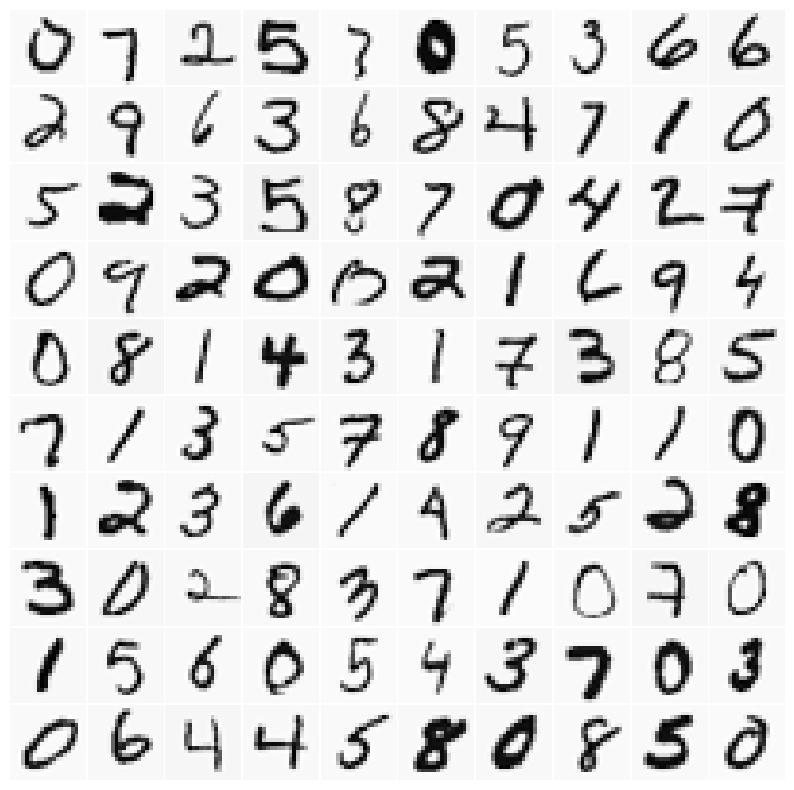

In [45]:
#  training data stored in arrays X, y
data = loadmat(os.path.join('Data', 'ex3data1.mat'))
X, y = data['X'], data['y'].ravel()

# set the zero digit to 0, rather than its mapped 10 in this dataset
y[y == 10] = 0

# get number of examples in dataset
m = y.size

# randomly permute examples, to be used for visualizing one 
# picture at a time
indices = np.random.permutation(m)

# Randomly select 100 data points to display
rand_indices = np.random.choice(m, 100, replace=False)
sel = X[rand_indices, :]

utils.displayData(sel)

###  Vectorizing logistic regression
You will be using multiple one-vs-all logistic regression models to build a multi-class classifier. Since there are 10 classes, you will need to train 10 separate logistic regression classifiers. To make this training efficient, it is important to ensure that your code is well vectorized. In this section, you will implement a vectorized version of logistic regression that does not employ any `for` loops.

#### Vectorizing the cost function
We will begin by writing a vectorized version of the cost function. Recall that in (unregularized) logistic regression, the cost function is 

$$ J(\boldsymbol{\theta}) = -\frac{1}{N}\sum_{i=1}^{N}y^{(i)} \ln\left(h_{\theta}(x^{(i)})\right)+ (1-y^{(i)})\ln\left(1-h_{\theta}(x^{(i)})\right),
$$ where $$h_{\theta}(x^{(i)})=\frac{1}{1+e^{-\boldsymbol{\theta}^T \boldsymbol{x}^{(i)}}}$$

It turns out that we can compute this quickly for all our examples by using matrix multiplication. Let us define $\boldsymbol{X}$ and $\boldsymbol{\theta}$ as

$$ 
 h_{\theta}(X)=\boldsymbol{X}\boldsymbol{\theta} = \begin{bmatrix}
(\boldsymbol{x}^{(1)})^T \boldsymbol{\theta}\\
\vdots \\
(\boldsymbol{x}^{(N)})^T \boldsymbol{\theta}
\end{bmatrix}
$$
This allows us to compute the products $(\boldsymbol{x}^{(i)})^T \boldsymbol{\theta}$ for all our examples $i$ in one line of code. Your job is to write the unregularized cost function `lrCostFunction`. Your implementation should use the strategy we presented above to calculate . You should also use a vectorized approach for the rest of the cost function. A fully vectorized version of `lrCostFunction` should not contain any loops.

First of all; as we have seen in class the sigmoid function can take values in the range $[0,1]$. So large positive values of X will lead to the sigmoid close to 1, while for large negative values, the sigmoid should be close to 0. The sigmoid function is defined as:

$$
g(z) = \cfrac{1}{1 + e^{-z}}
$$

Implement this function in the cell below so it can be called by the rest of the exercise.

In [46]:
#EDIT THIS CELL
def sigmoid(z):
    z = np.array(z)
    
    # You need to return the following variables correctly 
    # g = np.zeros(z.shape)

    # ==================== YOUR CODE HERE =========================
    g = 1 / (1 + np.exp(-z))

    # =============================================================
    return g

The following cell evaluates the sigmoid function at `z=0`. You should get a value of 0.5. You can also try different values for `z` to experiment with the sigmoid function.

In [47]:
# Test the implementation of sigmoid function here
z = 0
g = sigmoid(z)

print('g(', z, ') = ', g)

g( 0 ) =  0.5


#### Vectorizing the gradient
Recall that the gradient of the (unregularized) logistic regression cost is a vector defined as

$$ \nabla J(\boldsymbol{\theta}) = \frac{\delta J(\boldsymbol{\theta})}{\delta \boldsymbol{\theta}} =  \frac{1}{N}\sum_{i=1}^{N} \left(\frac{1}{1+e^{-\boldsymbol{\theta}^T \boldsymbol{x}^{(i)}}}-y^{(i)}\right)\boldsymbol{x}^{(i)}, $$

To vectorize this operation over the dataset, we start by writing out all the partial derivatives explicitly for all $\boldsymbol{\theta}_j$

$$ 
 \begin{bmatrix}
 \frac{\delta J(\boldsymbol{\theta})}{\delta \boldsymbol{\theta}_0}\\
\vdots \\
 \frac{\delta J(\boldsymbol{\theta})}{\delta \boldsymbol{\theta}_M}
\end{bmatrix} = \frac{1}{N} \begin{bmatrix}
 \sum_{i=1}^{N} \left(\frac{1}{1+e^{-\boldsymbol{\theta}^T \boldsymbol{x}^{(i)}}}-y^{(i)}\right)x^{(i)}_0\\
\vdots \\
 \sum_{i=1}^{N} \left(\frac{1}{1+e^{-\boldsymbol{\theta}^T \boldsymbol{x}^{(i)}}}-y^{(i)}\right)x^{(i)}_M
\end{bmatrix} = \frac{1}{N} \boldsymbol{X}^T \left(\frac{1}{1+e^{-\boldsymbol{\theta}^T \boldsymbol{x}^{(i)}}}-y^{(i)}\right)
$$
where 

$$
\left(\frac{1}{1+e^{-\boldsymbol{\theta}^T \boldsymbol{x}^{(i)}}}-y^{(i)}\right) = \begin{bmatrix}
 \left(\frac{1}{1+e^{-\boldsymbol{\theta}^T \boldsymbol{x}^{(1)}}}-y^{(1)}\right)\\
\vdots \\
  \left(\frac{1}{1+e^{-\boldsymbol{\theta}^T \boldsymbol{x}^{(N)}}}-y^{(N)}\right)\\
\end{bmatrix}
$$
is a $N$ vector and $\boldsymbol{x}^{(i)}$ is $M+1$ vector.

The expression above allows us to compute all the partial derivatives without any loops. If you are comfortable with linear algebra, we encourage you to work through the matrix multiplications above to convince yourself that the vectorized version does the same computations. Once you are done, complete the function `lrCostFunction` by implementing the gradient.

In [48]:
#EDIT THIS CELL
def lrCostFunction(theta, X, y, lambda_):
    N = y.size  # number of training examples

    # You need to return the following variables correctly 
    # J = 0
    # grad = np.zeros(theta.shape)

    # ====================== YOUR CODE HERE ======================
    J = - 1 / N * (y @ np.log(sigmoid(X @ theta)) + (1 - y) @ np.log(1 - sigmoid(X @ theta))) + lambda_/(2*N) * np.sum(theta[1:])

    print("theta: ", theta)
    print(theta[1:])
    print("concatenate: ", np.concatenate([np.zeros([1]), theta[1:]]))
    grad = 1/N * X.T @ (sigmoid(X @ theta) - y) + lambda_/N * np.concatenate([np.zeros([1]), theta[1:]])

   
    
    # =============================================================
    return J, grad

Once you are done test your `lrCostFunction` by executing the next cell.

In [41]:
theta_t = np.zeros(4); 
theta_t[:] = [-2, -1, 1, 2];
X_t = np.zeros((5,4));
X_t[:,0] = np.ones(5);
X_t[:,1:] = np.transpose(np.reshape(list(range(1,16)),(3,5))/10);
y_t = np.zeros(5)
y_t[:] =  [1, 0, 1, 0,1]; 
lambda_t = 3;
cost, grad = lrCostFunction(theta_t, X_t, y_t, lambda_t);

print('Cost: {:.3f}'.format(cost))
print('Expected cost: 2.534819\n')
print('Gradients:\n'); print(grad)
print('Expected gradients:\n 0.146561 -0.548558 0.724722 1.398003');

theta:  [-2. -1.  1.  2.]
[-1.  1.  2.]
concatenate:  [ 0. -1.  1.  2.]
Cost: 1.335
Expected cost: 2.534819

Gradients:

[ 0.14656137 -0.54855841  0.72472227  1.39800296]
Expected gradients:
 0.146561 -0.548558 0.724722 1.398003


#### Vectorizing regularized logistic regression
After you have implemented vectorization for logistic regression, you will now add regularization to the cost function. Recall that for regularized logistic regression, the cost function is defined as

$$ J(\boldsymbol{\theta}) = -\frac{1}{N}\sum_{i=1}^{N}y^{(i)} \ln\left(\frac{1}{1+e^{-\boldsymbol{\theta}^T \boldsymbol{x}^{(i)}}}\right)+ (1-y^{(i)})\ln\left(1-\frac{1}{1+e^{-\boldsymbol{\theta}^T \boldsymbol{x}^{(i)}}}\right) 
+ \frac{\lambda}{2N}\sum_{j=1}^{M}\theta_j,
$$

Note that you should not be regularizing $\theta_0$ which is used for the bias term. Correspondingly, the partial derivative of regularized logistic regression cost for $\theta_j$ is defined as

$$ \frac{\partial J(\theta)}{\partial \theta_0} = \frac{1}{N} \sum_{i=1}^N \left( h_\theta \left(x^{(i)}\right) - y^{(i)} \right) x_j^{(i)} \qquad \text{for } j =0 $$

$$ \frac{\partial J(\theta)}{\partial \theta_j} = \left( \frac{1}{N} \sum_{i=1}^N \left( h_\theta \left(x^{(i)}\right) - y^{(i)} \right) x_j^{(i)} \right) + \frac{\lambda}{N}\theta_j \qquad \text{for } j \ge 1 $$

Modify now your code in `lrCostFunction` to account for regularization.
Once again, you should not put any loops into your code.

### One-vs-all classication
In this part of the exercise, you will implement one-vs-all classification by training multiple regularized logistic regression classifiers, one for each of the $K$ classes in our dataset. In the handwritten digits dataset, $K=10$ , but your code should work for any value of $K$ .

You should now complete the code of the function "oneVsAll" to train one classifier for each class. In particular, your code should return all the classifier parameters in a matrix $\boldsymbol{\Theta}\in \mathcal{R}^{K\times M+1}$, where each row of $\boldsymbol{\Theta}$ corresponds to the learned logistic regression parameters for one class. You can do this with a for loop from $1$ to $K$, training each classifier independently.
    
Note that the $y$ argument to this function is a vector of labels from $1$ to $10$, where we have mapped the digit '0' to the label 10 (to avoid confusions with indexing). When training the classifier for class $k\in(1,\cdots,K)$ you will want a $N$-dimensional vector of labels $y_j\in(0,1)$ where $j$ indicates whether the $j$-th training instance belongs to class $k$ $(y_j=1)$, or if it belongs to a different class $(y_j=0)$ You may find logical arrays helpful for this task.

##### Learning parameters  using `scipy.optimize`


Note that instead of taking gradient descent steps, you will use the [`scipy.optimize` module](https://docs.scipy.org/doc/scipy/reference/optimize.html). SciPy is a `python` library for numerical computing. It provides an optimization module for minimization. The function `scipy.optimize.minimize` is the method to use for optimization problems (both constrained and unconstrained).

If you have completed the `lrCostFunction` correctly, `optimize.minimize` will converge on the right optimization parameters and return the final values of the cost and $\boldsymbol{\Theta}$. Notice you only needed to provide a function calculating the cost and the gradient.

In [49]:
#EDIT THIS CELL
def oneVsAll(X, y, num_labels, lambda_):    
   

    # Some useful variables
    n, m = X.shape

    # You need to return the following variables correctly 
    all_theta = np.zeros((num_labels, m + 1))
    Cost = np.zeros(num_labels)

    # Add ones to the X data matrix
    X = np.concatenate([np.ones((n, 1)), X], axis=1)
    initial_theta = np.zeros(X.shape[1])
    # set options for optimize.minimize
    options= {'maxiter': 50}

    # ====================== YOUR CODE HERE ======================

    for i in range(num_labels):
        y_i = np.where(y == i, 1, 0)
        res = optimize.minimize(fun=lrCostFunction, args=(X, y_i, lambda_), x0=initial_theta, options=options)
        Cost[i] = res.fun
        all_theta[i,:] = res.x
    
    # =============================================================
    return Cost, all_theta

Execute the next cell to test your function. 

In [50]:
num_labels = 10 # 10 labels, from 1 to 10
lambda_ = 0.1
Cost, all_theta = oneVsAll(X, y, num_labels, lambda_)
print(Cost);

theta:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



theta:  [-2.27372207e-01  0.00000000e+00  0.00000000e+00 -2.15446512e-07
  2.67280853e-06  7.03266255e-06 -1.85053578e-04 -2.96746646e-04
 -2.69909289e-04 -6.02052693e-05  3.31165618e-04  1.20190373e-04
 -2.32685063e-05  2.58662643e-05  4.27486008e-05  5.36138946e-05
  3.22786477e-05  1.02437662e-05  5.18493844e-07 -1.45114182e-07
  0.00000000e+00 -3.08463946e-08  5.04507551e-07  2.54414838e-06
 -3.38015471e-05 -8.70686604e-05 -5.25866201e-04 -1.72090160e-03
 -2.40750594e-03 -9.70608074e-04  5.93360559e-04  7.35474952e-04
 -3.03299612e-05 -7.00070254e-05  6.48648068e-05 -1.62043585e-05
  1.37124178e-05  3.24189893e-05  4.30798612e-05  9.38668042e-06
  2.61129333e-06  2.43520666e-07 -4.61388652e-06  1.61265028e-05
  9.81731089e-05  8.06119411e-04 -1.26005397e-03 -3.96433596e-03
 -4.73866413e-03 -2.98440981e-03 -9.67842204e-04  2.94602739e-03
  7.24977738e-04 -5.18206731e-03 -7.75864998e-03 -7.73638717e-03
 -4.22734108e-03 -1.46156052e-03 -5.17694438e-04  1.25528939e-05
 -1.17066079e-05 

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



theta:  [-9.19475708e+00  0.00000000e+00  0.00000000e+00 -6.57187892e-06
  6.24108077e-05  1.06566725e-04  1.04369271e-05 -1.00285202e-02
 -8.50290804e-03  6.72102985e-04  3.97743958e-05 -1.09376188e-05
  8.06944536e-05  2.30390706e-04  8.88532719e-04  2.53418021e-03
  1.92629259e-03  2.91000568e-04  1.24207257e-05 -4.42013358e-06
  0.00000000e+00 -9.14715932e-08 -7.16224914e-06  1.00693742e-04
 -8.95311930e-05  3.87293985e-04  1.48596234e-02  5.14620824e-04
 -3.62562842e-02 -4.97867361e-02 -2.94597429e-02  5.28552294e-03
  1.69791333e-03 -3.83695739e-03 -2.42124522e-03 -7.36409561e-03
  1.07250441e-02  2.26454762e-02  1.32883954e-02  7.36298362e-04
  4.60078347e-04  6.47070355e-07 -1.29805913e-04  3.76264168e-04
  1.13372309e-02  1.29352057e-02 -1.28218479e-01 -3.10065744e-01
 -2.57593939e-01 -3.92269324e-02  6.06741497e-02 -3.47704907e-02
  1.24945993e-02 -8.30331788e-02 -3.73129740e-01 -7.48452166e-01
 -5.99041854e-01 -2.72564183e-01 -1.55920809e-01  5.01970212e-04
 -5.47301985e-03 

#### One-vs-all prediction
After training your one-vs-all classifier, you can now use it to predict the digit contained in a given image. For each input, you should compute the 'probability' that it belongs to each class using the trained logistic regression classifiers. Your one-vs-all prediction function will pick the class for which the corresponding logistic regression classifier outputs the highest probability and return the class label $(1,2,\cdots,K)$ as the prediction for the input example.
    You should now complete the function predictOneVsAll to use the one-vs-all classifier to make predictions. Once you are done, run the code below to call your predictOneVsAll function using the learned value of $\boldsymbol{\Theta}$ . You should see that the training set accuracy is about 95.4% (i.e., it classifies 95.4% of the examples in the training set correctly).

In [9]:
#EDIT THIS CELL
def predictOneVsAll(all_theta, X):    
  
    # Make sure the input has two dimensions
    if X.ndim == 1:
        X = X[None]  # promote to 2-dimensions
    
    # useful variables
    n, m = X.shape;
    num_labels = all_theta.shape[0]

    # You need to return the following variables correctly 
    p = np.zeros(X.shape[0])

    # ====================== YOUR CODE HERE ======================
    # make a copy of X, to avoid changing the original array, since numpy arrays
    # are passed by reference to functions


    # =============================================================
    return p

In [10]:
pred = predictOneVsAll(all_theta, X)
print('Training Set Accuracy: {:.1f}%'.format(np.mean(pred == y) * 100))

Training Set Accuracy: 10.0%


Now you can  display some images from the training set one at a time, while at the same time printing out the predicted label for the displayed image.

One vs All Logistic Regression: 0.0


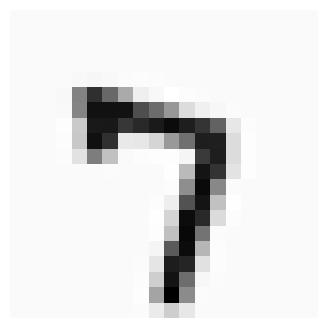

In [11]:
if indices.size > 0:
    i, indices = indices[0], indices[1:]
    utils.displayData(X[i, :], figsize=(4, 4))
    pred = predictOneVsAll(all_theta, X[i, :])
    print('One vs All Logistic Regression: {}'.format(*pred))
else:
    print('No more images to display!')